In [1]:
import torch
from torch import nn
from d2l import torch as d2l
import os

In [2]:
# 带有 注意力机制的解码器 基本接口
class AttentionDecoder(d2l.Decoder):
    """带有注意力机制的解码器基本接口"""
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)
        
    @property
    def attention_weight(self):
        raise NotImplementedError

# Model

In [3]:
# 实现带有 Bahdanau注意力 的 循环神经网络RNN 解码器
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        # 调用父类AttentionDecoder的构造函数进行初始化
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        # 创建一个加性注意力机制的实例，用于计算注意力权重
        self.attention = d2l.AdditiveAttention(num_hiddens, num_hiddens, num_hiddens, dropout)  
        # 创建一个嵌入层，用于将输入的整数序列进行嵌入表示
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # 创建一个GRU层，用于实现循环神经网络的计算
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers, dropout=dropout)  
        # 创建一个线性层，将隐藏状态映射到词汇表大小的输出
        self.dense = nn.Linear(num_hiddens, vocab_size)
        
    def init_state(self, enc_outputs, enc_valid_lens, *args):
        # 将编码器的输出解包为outputs和hidden_state
        outputs, hidden_state = enc_outputs
        # 对outputs进行维度变换，将batch维和时间步维交换，保持与解码器输入的一致性
        # 返回初始化的解码器隐藏状态
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)
    
    def forward(self, X, state):
        # 解析输入的状态信息，包括编码器的输出、隐藏状态和有效长度
        enc_outputs, hidden_state, enc_valid_lens = state
        # 对输入序列进行嵌入表示，并进行维度变换，将batch维和时间步维交换
        X = self.embedding(X).permute(1, 0, 2)
        # 初始化输出列表和注意力权重列表
        outputs, self._attention_weights = [], []
        for x in X:
            # 获取当前时间步的查询向量，将隐藏状态的最后一个时间步的特征进行维度扩展
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # 计算注意力上下文向量，通过注意力机制对编码器的输出进行加权求和
            context = self.attention(query, enc_outputs, enc_outputs, enc_valid_lens)  
            # 将注意力上下文向量与当前时间步的输入进行拼接，用于输入到循环神经网络
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # 执行循环神经网络的前向计算，得到输出和更新后的隐藏状态
            out, hidden_state = self.rnn(x.permute(1,0,2),hidden_state)
            # 将输出和注意力权重添加到对应的列表中
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # 将输出列表中的结果进行拼接，并通过线性层进行映射
        outputs = self.dense(torch.cat(outputs, dim=0))
        # 对输出进行维度变换，将batch维和时间步维交换，并返回更新后的状态信息
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state, enc_valid_lens]  
    
    @property
    def attention_weights(self):
        # 返回注意力权重
        return self._attention_weights

model demo

In [4]:
# 测试Bahdanau注意力解码器
# 创建编码器和解码器的实例
encoder = d2l.Seq2SeqEncoder(vocab_size = 10, embed_size=8, num_hiddens=16, num_layers=2)  
encoder.eval()
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16,num_layers=2)  
decoder.eval()
# 创建输入序列X
X = torch.zeros((4,7), dtype=torch.long)
# 初始化解码器的状态
state = decoder.init_state(encoder(X), None)
# 执行解码器的前向计算
output, state = decoder(X, state)
# 输出结果的形状以及状态信息的长度和形状
output.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape

(torch.Size([4, 7, 10]), 3, torch.Size([4, 7, 16]), 2, torch.Size([4, 16]))

# Dataset

In [5]:
def read_data_nmt():
    """载入 “英语-法语” 数据集 """
    # 下载并解压数据集
    data_dir = d2l.download_extract('fra-eng')
    # 打开数据文件，使用utf-8编码读取文件内容
    with open(os.path.join(data_dir, 'fra.txt'), 'r', encoding='utf-8') as f:
        # 返回读取的文件内容
        return f.read()

In [6]:
def preprocess_nmt(text):
    """预处理 “英语-法语” 数据集"""
    def no_space(char, prev_char):
        # 检查是否需要在字符之前添加空格
        return char in set(',.!?') and prev_char != ''
    # 替换特殊字符为空格并转换为小写
    text = text.replace('\u202f', ' ').replace('\xa0',' ').lower()
    # 根据规则在字符之前添加空格
    out = [
        ' ' + char if i > 0 and no_space(char, text[i - 1]) else char
        for i, char in enumerate(text)]
    # 将处理后的字符列表连接成字符串并返回
    return ''.join(out)

In [7]:
def tokenize_nmt(text, num_examples=None):
    """词元化 “英语-法语” 数据数据集 """
    # 初始化源语言和目标语言的列表
    source, target = [], []
    # 对每行文本进行遍历
    for i, line in enumerate(text.split('\n')):
        # 如果指定了num_examples，并且超过了指定数量，则退出循环
        if num_examples and i > num_examples:
            break
        # 将每行文本按制表符分割成源语言和目标语言的部分
        parts = line.split('\t')
        # 如果分割后有两个部分，说明包含了源语言和目标语言的内容
        if len(parts) == 2:
            # 将源语言部分以空格为分隔符进行词元化，存储到源语言列表中
            source.append(parts[0].split(' '))
            # 将目标语言部分以空格为分隔符进行词元化，存储到目标语言列表中
            target.append(parts[1].split(' '))
    # 返回词元化后的源语言列表和目标语言列表
    return source, target

In [8]:
def truncate_pad(line, num_steps, padding_token):
    """截断或填充文本序列"""
    # 如果文本序列的长度超过了指定的步数
    if len(line) > num_steps:
        # 截断文本序列，保留前num_steps个元素
        return line[:num_steps]
    # 在文本序列末尾填充padding_token，使其长度达到num_steps
    return line + [padding_token] * (num_steps - len(line))

In [9]:
def build_array_nmt(lines, vocab, num_steps):
    """将机器翻译的文本序列转换成小批量"""
    # 将文本序列中的每个词根据词汇表转换为对应的索引
    lines = [vocab[l] for l in lines]
    # 在每个文本序列末尾添加<eos>表示句子结束的索引
    lines = [l + [vocab['<eos>']] for l in lines]
    # 将每个文本序列截断或填充为固定长度，并转换为tensor形式
    array = torch.tensor([ truncate_pad(l, num_steps, vocab['<pad>']) for l in lines ])
    # 计算有效长度，即非填充部分的长度
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    # 返回转换后的tensor形式的文本序列和有效长度
    return array, valid_len

In [10]:
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """返回翻译数据集的迭代器和词汇表"""
    # 载入并预处理文本数据集
    text = preprocess_nmt(read_data_nmt())
    # 将文本数据集进行词元化
    source, target = tokenize_nmt(text, num_examples)
    # 构建源语言的词汇表对象
    src_vocab = d2l.Vocab(source, min_freq=2,
                         reserved_tokens=['<pad>','<bos>','<eos>'])
    # 构建目标语言的词汇表对象
    tgt_vocab = d2l.Vocab(target, min_freq=2,
                         reserved_tokens=['<pad>','<bos>','<eos>'])
    # 将源语言文本序列转换为小批量数据，并获取有效长度
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)  
    # 将目标语言文本序列转换为小批量数据，并获取有效长度
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    # 构建数据集的数组
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    # 构建数据迭代器
    data_iter = d2l.load_array(data_arrays, batch_size)
    # 返回数据迭代器和词汇表对象
    return data_iter, src_vocab, tgt_vocab

# Train

loss 0.018, 8986.1 tokens/sec on cuda:0


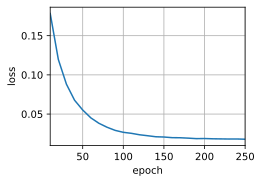

In [11]:
# 训练
# 设置嵌入大小、隐藏层大小、层数和丢弃率
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
# 设置批量大小和序列长度
batch_size, num_steps = 64, 10
# 设置学习率、训练轮数和设备（GPU或CPU）
lr, num_epochs, device = 0.005, 250, d2l.try_gpu()

# 载入翻译数据集，并获取数据迭代器和词汇表
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps)  
# 创建源语言的编码器实例
encoder = d2l.Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)  
# 创建目标语言的带有注意力机制的解码器实例
decoder = Seq2SeqAttentionDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)   
# 创建编码-解码模型实例
net = d2l.EncoderDecoder(encoder, decoder)
# 训练序列到序列模型
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

# Model Prediction and Evaluation

In [16]:
# 将几个英语句子翻译成汉语
# 英语句子列表
engs = ['go', "i lost .", 'he\'s calm .', 'i\'m home .'] 
# 对应的汉语句子列表
fras = ['va !', 'j\' ai perdu .', 'il est calme .', 'je suis chez moi .']
# 遍历英语句子和汉语句子的对应关系
for eng, fra in zip(engs, fras):
    # 使用训练好的模型net对英语句子进行翻译，并获取注意力权重序列
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(net, eng, src_vocab,
                                                               tgt_vocab, num_steps, device, True)   
    # 打印英语句子、翻译结果和BLEU分数
    print(f' {eng} => {translation} ({fra}), ',
         f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

 go => dégage  ! (va !),  bleu 0.000
 i lost . => j'ai perdu . (j' ai perdu .),  bleu 0.492
 he's calm . => il est malade . (il est calme .),  bleu 0.658
 i'm home . => je suis chez moi . (je suis chez moi .),  bleu 1.000


# Attention Weight Visualization

In [13]:
# 将 注意力权重 序列 进行拼接，并调整形状
attention_weights = torch.cat([step[0][0][0] for step in dec_attention_weight_seq], 0).reshape((1, 1, -1, num_steps)) 

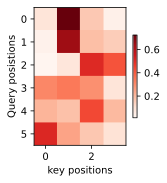

In [14]:
# 可视化注意力权重
# 显示注意力权重的热图，仅显示与输入英语句子对应的位置
d2l.show_heatmaps(attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
                 xlabel = 'key positions', ylabel = 'Query posistions')